Pengolahan CItra Digital

*   Nama : Muhammad Hallaj Nashrulloh
*   NIM : 2206031
*   Kelas : Informatika-A




---

___

Eksperimen ke-empat

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# U-Net Model

def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D(2)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output Layer
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)

    return Model(inputs, outputs, name="U-Net")

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.2810 - loss: 0.6933
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.7762 - loss: 0.6877
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7762 - loss: 0.6769
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.7762 - loss: 0.6551
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.7762 - loss: 0.6047
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.7762 - loss: 0.5005
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7762 - loss: 2.7463
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7762 - loss: 0.4971
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.7762 - loss: 0.6054
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.7689 - loss: 0.6329
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


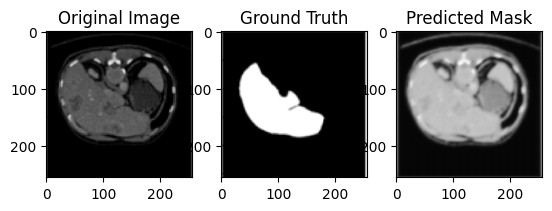

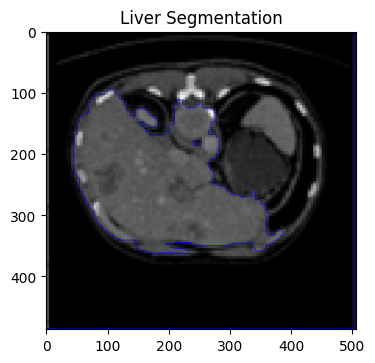

In [14]:
# Load Sample Image (Replace with your dataset)
def load_sample_image():
    image = cv2.imread("/content/k.png")  # Replace with dataset
    image = cv2.resize(image, (256, 256))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image / 255.0

def load_sample_mask():
    mask = cv2.imread("/content/c.png", cv2.IMREAD_GRAYSCALE)  # Replace with actual mask
    mask = cv2.resize(mask, (256, 256))
    return np.expand_dims(mask, axis=-1) / 255.0

def liver_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Menandai batas segmentasi dengan warna merah
    return image

# Load Data
image = load_sample_image()
mask = load_sample_mask()

# Prepare Data for Training
X_train = np.expand_dims(image, axis=0)
y_train = np.expand_dims(mask, axis=0)

# Compile & Train Model
unet_model = build_unet((256, 256, 3))
unet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

unet_model.fit(X_train, y_train, epochs=10, batch_size=1)

# Predict & Show Results
pred_mask = unet_model.predict(X_train)[0]
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground Truth")
plt.subplot(1, 3, 3)
plt.imshow(pred_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")
plt.figure(figsize=(4, 4))
plt.imshow(cv2.cvtColor(liver_segmented, cv2.COLOR_BGR2RGB))
plt.title("Liver Segmentation")
plt.show()

___

---

Eksperimen yang ketiga

Import Library

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Edge Detection (Deteksi Tepi)

In [2]:
def edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)  # Mengurangi ambang batas untuk deteksi lebih akurat
    return edges

Noise Reduction (Reduksi Noise)

In [3]:
def noise_reduction(image):
    return cv2.medianBlur(image, 5)  # Menggunakan median blur untuk mempertahankan detail tepi


Histogram Equalization (Peningkatan Kontras)

In [4]:
def histogram_equalization(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)  # Menggunakan CLAHE untuk peningkatan kontras adaptif

Adaptive Thresholding (Binarisasi Adaptif)

In [5]:
def adaptive_thresholding(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

Morphological Operations (Operasi Morfologi)

In [6]:
def morphological_operations(image):
    kernel = np.ones((3,3), np.uint8)
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)  # Menutup lubang kecil dalam area segmentasi
    return closing

Contour Detection (Deteksi Kontur)

In [7]:
def contour_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    result = image.copy()
    cv2.drawContours(result, contours, -1, (0, 255, 0), 2)
    return result

Liver Segmentation (Segmentasi Hati)

In [8]:
def liver_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Menandai batas segmentasi dengan warna merah
    return image

Import Image

In [10]:
if __name__ == "__main__":
    image = cv2.imread("/content/k.png")
    if image is None:
        raise FileNotFoundError("Image file not found. Please check the file path.")


Proses

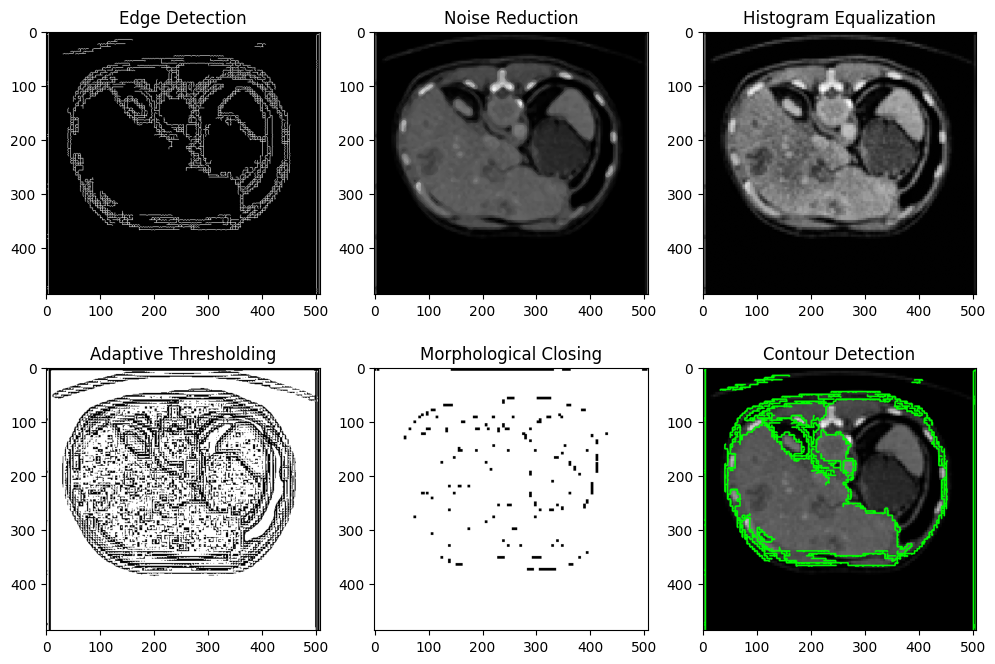

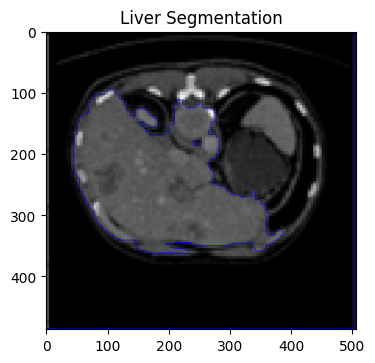

In [11]:
    edges = edge_detection(image)
    blurred = noise_reduction(image)
    enhanced = histogram_equalization(image)
    adaptive_thresh = adaptive_thresholding(image)
    morph_close = morphological_operations(adaptive_thresh)
    contours = contour_detection(image)
    liver_segmented = liver_segmentation(image)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")

    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
    plt.title("Noise Reduction")

    plt.subplot(2, 3, 3)
    plt.imshow(enhanced, cmap='gray')
    plt.title("Histogram Equalization")

    plt.subplot(2, 3, 4)
    plt.imshow(adaptive_thresh, cmap='gray')
    plt.title("Adaptive Thresholding")

    plt.subplot(2, 3, 5)
    plt.imshow(morph_close, cmap='gray')
    plt.title("Morphological Closing")

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
    plt.title("Contour Detection")

    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(liver_segmented, cv2.COLOR_BGR2RGB))
    plt.title("Liver Segmentation")


    plt.show()

---

___

Eksperimen yang Ketiga

Import Image

In [ ]:
image_path = '/content/k.png'
image = cv2.imread(image_path)


Segmentasi

In [ ]:
def liver_segmentation(image):
    """
    Fungsi untuk segmentasi hati menggunakan adaptive threshold dan filtering.
    """
    # Konversi ke grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding dengan Otsu untuk segmentasi yang lebih adaptif
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Menggunakan morphological closing untuk memperhalus hasil segmentasi
    kernel = np.ones((7, 7), np.uint8)
    morph = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

    return morph

Gaussian Blur (Noise Reduction)

In [ ]:
def gaussian_blur(image, kernel_size=(5,5), sigma=1.5):
    """
    Mengurangi noise dengan filter Gaussian
    - kernel_size: ukuran kernel (harus ganjil)
    - sigma: deviasi standar Gaussian
    """
    return cv2.GaussianBlur(image, kernel_size, sigma)



Edge Detection (Canny)

In [ ]:
def canny_edge_detection(image, low_threshold=50, high_threshold=150):
    """
    Deteksi tepi menggunakan algoritma Canny
    - low_threshold: threshold bawah untuk hysteresis
    - high_threshold: threshold atas
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    return edges

Histogram Equalization

In [ ]:
def histogram_equalization(image):
    """Meningkatkan kontras dengan equalisasi histogram"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    return equalized


Morfologi - Erosi & Dilasi

In [ ]:
def morphological_operations(image, operation='erode', kernel_size=3):
    """
    Operasi morfologi dasar
    - operation: 'erode' atau 'dilate'
    - kernel_size: ukernel struktur
    """
    kernel = np.ones((kernel_size,kernel_size), np.uint8)
    if operation == 'erode':
        return cv2.erode(image, kernel, iterations=1)
    elif operation == 'dilate':
        return cv2.dilate(image, kernel, iterations=1)

# Contoh penggunaan
segmented = liver_segmentation(image) # Melakukan segmentasi dan menyimpan hasilnya di 'segmented'
eroded = morphological_operations(segmented, 'erode')  # Sekarang 'segmented' sudah didefinisikan
dilated = morphological_operations(segmented, 'dilate')


Harris Corner Detection

In [ ]:
def detect_corners(image, block_size=2, ksize=3, k=0.04):
    """Deteksi sudut menggunakan metode Harris"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    corners = cv2.cornerHarris(gray, block_size, ksize, k)

    # Thresholding untuk deteksi sudut
    image[corners > 0.01*corners.max()] = [0,0,255]  # Tandai dengan titik merah
    return image


Segmentasi Watershed

In [ ]:
def watershed_segmentation(image):
    """Segmentasi menggunakan algoritma Watershed"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Hilangkan noise
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Marker labelling
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Watershed
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)

    # Visualisasi
    image[markers == -1] = [255,0,0]  # Tandai batas
    return image

Adaptive Thresholding

In [ ]:
def adaptive_threshold(image, block_size=11, C=2):
    """Threshold adaptif untuk pencahayaan tidak merata"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, block_size, C)

Deteksi anomali

In [ ]:
def detect_abnormalities(liver_mask, original_image):
    """
    Fungsi untuk mendeteksi area abnormal berdasarkan segmentasi.
    """
    # Ambil area yang tersegmentasi
    contours, _ = cv2.findContours(liver_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Gambarkan kontur pada gambar asli
    result_image = original_image.copy()
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 1000:  # Hanya pertimbangkan area signifikan
            cv2.drawContours(result_image, [cnt], -1, (0, 255, 0), 2)

    return result_image

Proses

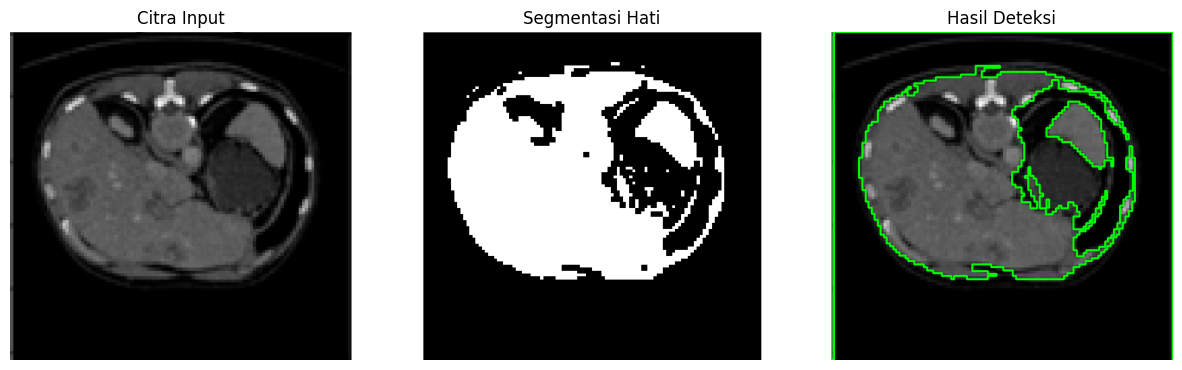

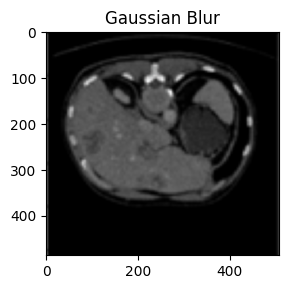

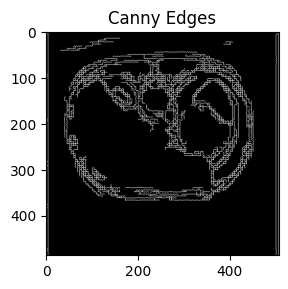

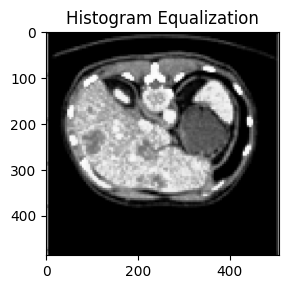

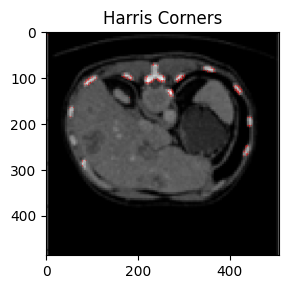

<Figure size 640x480 with 0 Axes>

In [ ]:
# Cek apakah gambar berhasil dimuat
if image is None:
    print("Gagal memuat gambar. Pastikan path benar.")
else:
    # Segmentasi hati
    liver_mask = liver_segmentation(image)

    # Deteksi area abnormal
    result = detect_abnormalities(liver_mask, image)


    # Visualisasi hasil
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Citra Input")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(liver_mask, cmap='gray')
    plt.title("Segmentasi Hati")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Hasil Deteksi")
    plt.axis("off")


    plt.figure(figsize=(3, 3))
    blurred = gaussian_blur(image)
    plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
    plt.title('Gaussian Blur')
    plt.show()

    plt.figure(figsize=(3, 3))
    edges = canny_edge_detection(image)
    plt.imshow(edges, cmap='gray')
    plt.title('Canny Edges')
    plt.show()

    plt.figure(figsize=(3, 3))
    equalized = histogram_equalization(image)
    plt.imshow(equalized, cmap='gray')
    plt.title('Histogram Equalization')
    plt.show()

    plt.figure(figsize=(3, 3))
    corner_image = detect_corners(image.copy())
    plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
    plt.title('Harris Corners')
    plt.show()

    plt.tight_layout()
    plt.show()


___

---

Eksperiman Yang Pertama

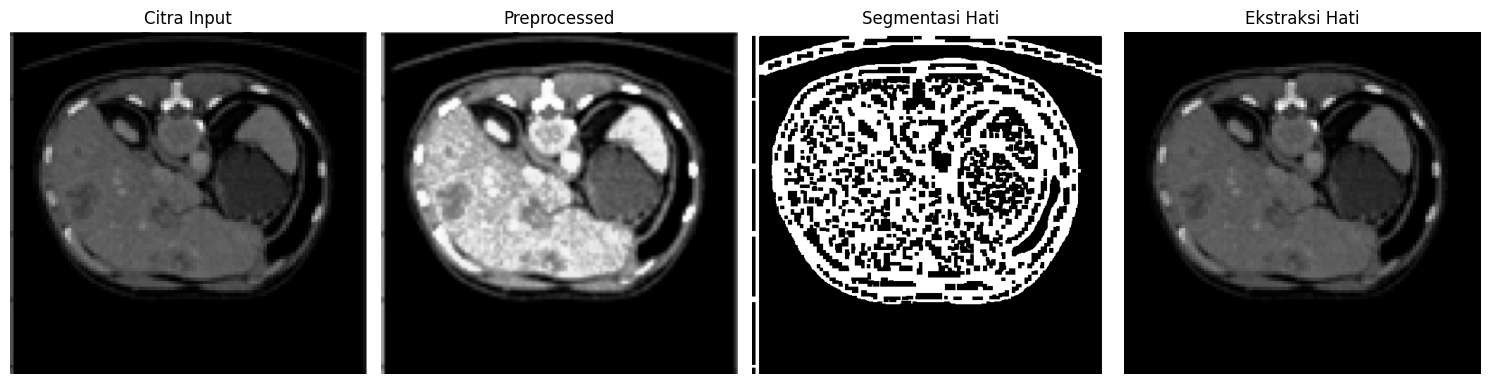

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    """
    Preprocessing gambar: grayscale, histogram equalization, dan Gaussian blur.
    """
    # Konversi ke grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Histogram equalization untuk meningkatkan kontras
    equalized = cv2.equalizeHist(gray)

    # Gaussian blur untuk mengurangi noise
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)

    return blurred

def liver_segmentation(image):
    """
    Segmentasi hati menggunakan adaptive thresholding.
    """
    # Adaptive thresholding
    thresholded = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)

    # Morphological operation untuk membersihkan hasil
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

    return morph

def extract_liver_region(segmented, original_image):
    """
    Ekstraksi area hati berdasarkan segmentasi.
    """
    # Cari kontur
    contours, _ = cv2.findContours(segmented, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter kontur berdasarkan ukuran (hindari noise kecil)
    liver_contour = max(contours, key=cv2.contourArea)  # Pilih kontur terbesar

    # Buat mask baru untuk hati
    liver_mask = np.zeros_like(segmented)
    cv2.drawContours(liver_mask, [liver_contour], -1, 255, thickness=cv2.FILLED)

    # Gabungkan mask dengan gambar asli
    liver_segmented = cv2.bitwise_and(original_image, original_image, mask=liver_mask)

    return liver_segmented, liver_mask

# Load gambar
image_path = '/content/k.png'  # Path ke gambar input
image = cv2.imread(image_path)

# Preprocessing
preprocessed = preprocess_image(image)

# Segmentasi hati
segmented = liver_segmentation(preprocessed)

# Ekstraksi area hati
liver_segmented, liver_mask = extract_liver_region(segmented, image)

# Visualisasi hasil
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Citra Input")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(preprocessed, cmap='gray')
plt.title("Preprocessed")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(segmented, cmap='gray')
plt.title("Segmentasi Hati")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(liver_segmented, cv2.COLOR_BGR2RGB))
plt.title("Ekstraksi Hati")
plt.axis("off")

plt.tight_layout()
plt.show()


---